In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Airplane delays") \
    .getOrCreate()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

plt.xkcd()  # Yes...

In [8]:
# You dont need this. In some columns there is 'NA' a value. So we start with all strings and later
# cast to Longs - cause thats what RandomForestClassifier needs.

from pyspark.sql.types import IntegerType, LongType, StringType, StructField, StructType

fields = [StructField("Year", IntegerType(), True),
          StructField("Month", StringType(), False),           
          StructField("DayofMonth", IntegerType(), False),            
          StructField("DayofWeek", IntegerType(), False),            
          StructField("DepTime", LongType(), False),            
          StructField("CRSDeptime", LongType(), True),
          StructField("Arrtime", LongType(), True),
          StructField("CRSArrTime", StringType(), True),
          StructField("UniqueCarrier", StringType(), True),
          StructField("FlightNum", StringType(), True),    
          StructField("TailNum", StringType(), True),
          StructField("ActualElapsedTime", LongType(), True),
          StructField("CRSElapsedTime", LongType(), True),
          StructField("AirTime", LongType(), True),
          StructField("ArrDelay", StringType(), True),
          StructField("DepDelay", StringType(), True),
          StructField("Origin", StringType(), True),
          StructField("Dest", StringType(), True),
          StructField("Distance", LongType(), True),
          StructField("TaxiIn", LongType(), True),
          StructField("TaxiOut", LongType(), True),
          StructField("Cancelled", IntegerType(), True),
          StructField("CancellationCode", StringType(), True),
          StructField("Diverted", LongType(), True),
          StructField("CarrierDelay", StringType(), True),
          StructField("WeatherDelay", StringType(), True),
          StructField("NASDelay", StringType(), True),
          StructField("SecurityDelay", StringType(), True),
          StructField("LateAirCraftDelay", StringType(), True)]


          
          

In [ ]:
#You can download the datafile by removing the comments in the next two lines
#import urllib
#f = urllib.urlretrieve("http://beehub.nl/surfsara-hadoop/public/2008.csv.gz", "data/2008.csv.gz")

In [9]:
#dfRaw = spark.read.option("header", "true").csv("data/2008.csv.gz", StructType(fields))
dfRawdata = spark.read.option("header", "true").csv("data/2008.csv.gz")

dfRawdata.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [15]:
dfRaw = dfRawdata.sample(False, 0.5, 12345)

In [57]:
dff = dfRaw.filter(dfRaw['DepDelay']!='NA').filter(dfRaw['Month']!='NA').filter(dfRaw['ArrDelay']!='NA') \
           .filter(dfRaw['UniqueCarrier']!='NA').filter(dfRaw['DayofMonth']!='NA').filter(dfRaw['DayofWeek']!='NA') \
            .filter(dfRaw['CRSDeptime']!= 'NA').filter(dfRaw['Origin']!='NA').filter(dfRaw['Dest']!='NA') \
           .filter(dfRaw['Distance']!='NA')

df = dff.select(dff['Month'].cast(LongType()), dff['DayofMonth'].cast(LongType()), 
                     dff['DayofWeek'].cast(LongType()), dff['DepDelay'].cast(LongType()),
                     dff['Origin'],dff['ArrDelay'].cast(LongType()),dff['CRSDepTime'].cast(LongType()),
                     dff['Distance'].cast(LongType()), dff['Dest'],dff['UniqueCarrier'])
df.printSchema()


root
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayofWeek: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- ArrDelay: long (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- Distance: long (nullable = true)
 |-- Dest: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)



In [59]:
printSample = df.head()
from IPython.display import display, HTML

th = ["<th>" + d + "</th>" for d in df.columns]
td = ["<td>" + str(d) + "</td>" for d in printSample]

display(HTML("<table><thead><tr>" + "".join(th) + "</tr></thead><tbody><tr>" + "".join(td) + "</tr></tbody></table>"))

Month,DayofMonth,DayofWeek,DepDelay,Origin,ArrDelay,CRSDepTime,Distance,Dest,UniqueCarrier
1,3,4,8,IAD,-14,1955,810,TPA,WN


In [60]:
from pyspark.sql.types import IntegerType, LongType
#dff = df.filter(df["ArrDelay"]!= 'NA')
df.select(df['ArrDelay']).describe("ArrDelay").show()
#  shorter and equivalent
#dff[["ArrDelay"]].describe("ArrDelay").show()

+-------+------------------+
|summary|          ArrDelay|
+-------+------------------+
|  count|           3427918|
|   mean| 8.190097896157376|
| stddev|38.590046832859045|
|    min|              -129|
|    max|              2461|
+-------+------------------+



In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
grouped = df[['DepDelay', 'Month']].groupby('Month').mean()
grouped_sorted = grouped.sort(grouped['Month'].cast(IntegerType())).drop('avg(Month)')
#grouped.show()
#grouped.printSchema()
pdf = grouped_sorted.toPandas()


In [62]:
pdf

,Month,avg(DepDelay)
0,1,11.447720
1,2,13.583625
2,3,12.484457
3,4,8.223957
4,5,7.625891
5,6,13.605372
6,7,11.836564
7,8,9.588666
8,9,3.946456
9,10,3.836038


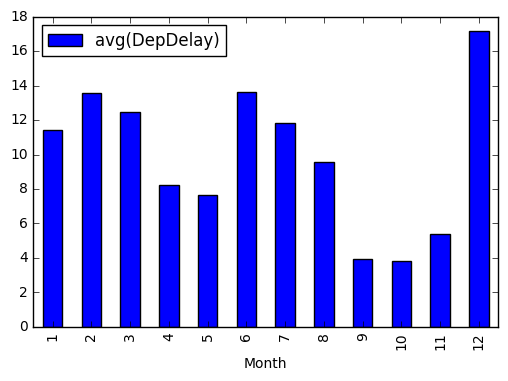

In [63]:
pdf.plot(kind='bar', x='Month')

In [64]:
grouped1 = df.select(df['DepDelay'], df['UniqueCarrier']).groupby('UniqueCarrier').mean()
carrier = grouped1.sort('avg(DepDelay)', ascending=False)
#carrier.show()

cpd = carrier.toPandas()
cpd[:10]

,UniqueCarrier,avg(DepDelay)
0,UA,14.043470
1,AA,13.331330
2,CO,13.208750
3,B6,12.715275
4,YV,12.106340
5,EV,11.893666
6,OH,11.542797
7,XE,11.289695
8,MQ,10.544798
9,WN,10.343904


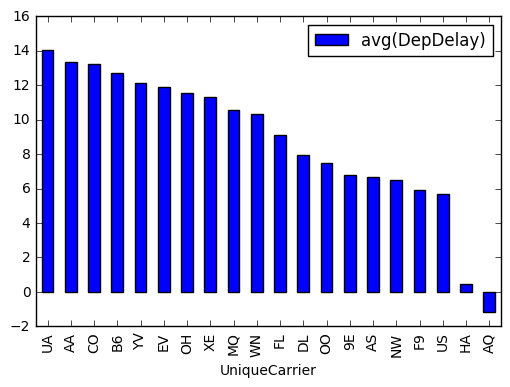

In [65]:
cpd.plot(kind='bar', x=cpd['UniqueCarrier'])

In [43]:
aqs = df.filter(df['UniqueCarrier'] == 'AQ')

aqs[["DepDelay"]].describe("DepDelay").show()

+-------+-------------------+
|summary|           DepDelay|
+-------+-------------------+
|  count|               3838|
|   mean|-1.1784783741532048|
| stddev| 15.389587088403365|
|    min|                -61|
|    max|                336|
+-------+-------------------+



month: winter months should have more delays than summer months
day of month: this is likely not a very predictive variable, but let's keep it in anyway
day of week: weekend vs. weekday
hour of the day: later hours tend to have more delays
Carrier: we might expect some carriers to be more prone to delays than others
Destination airport: we expect some airports to be more prone to delays than others
Distance: interesting to see if this variable is a good predictor of delay


In [66]:
orddf = df.filter(df['Origin']=='ORD').drop(df['Origin'])
orddf.show()

+-----+----------+---------+--------+--------+----------+--------+----+-------------+
|Month|DayofMonth|DayofWeek|DepDelay|ArrDelay|CRSDepTime|Distance|Dest|UniqueCarrier|
+-----+----------+---------+--------+--------+----------+--------+----+-------------+
|    1|        25|        5|      31|      36|      1742|     316| CLE|           XE|
|    1|         4|        5|       8|       7|       650|     719| EWR|           XE|
|    1|        10|        4|      -5|      12|      1205|     925| IAH|           XE|
|    1|        24|        4|      -6|      -7|       845|     719| EWR|           XE|
|    1|        16|        3|       0|     -30|      1600|     719| EWR|           XE|
|    1|         9|        3|       5|      -6|      1500|     925| IAH|           XE|
|    1|         2|        3|      -4|      -6|       850|     719| EWR|           XE|
|    1|        25|        5|      50|      38|      1240|     719| EWR|           XE|
|    1|        20|        7|     -10|     -30|      17

In [67]:
from pyspark.sql import functions as F

OrdDelayeddf = orddf.withColumn('label', F.when(orddf['DepDelay'] > 5, 1.0).otherwise(0.0))
OrdDelayeddf.show()

+-----+----------+---------+--------+--------+----------+--------+----+-------------+-----+
|Month|DayofMonth|DayofWeek|DepDelay|ArrDelay|CRSDepTime|Distance|Dest|UniqueCarrier|label|
+-----+----------+---------+--------+--------+----------+--------+----+-------------+-----+
|    1|        25|        5|      31|      36|      1742|     316| CLE|           XE|  1.0|
|    1|         4|        5|       8|       7|       650|     719| EWR|           XE|  1.0|
|    1|        10|        4|      -5|      12|      1205|     925| IAH|           XE|  0.0|
|    1|        24|        4|      -6|      -7|       845|     719| EWR|           XE|  0.0|
|    1|        16|        3|       0|     -30|      1600|     719| EWR|           XE|  0.0|
|    1|         9|        3|       5|      -6|      1500|     925| IAH|           XE|  0.0|
|    1|         2|        3|      -4|      -6|       850|     719| EWR|           XE|  0.0|
|    1|        25|        5|      50|      38|      1240|     719| EWR|         

In [68]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# define the feature columns to put in the feature vector
#featureCols = ['Month', 'DayofMonth', 'DayofWeek', 'DepDelay', 'CRSDepTime', 'Distance', 'UniqueCarrier','Dest' ]
featureCols = ['Month', 'DayofMonth', 'DayofWeek', 'Distance', 'CRSDepTime', 'Carrier']
stringIndexer = StringIndexer(inputCol='UniqueCarrier', outputCol='Carrier')
si_model = stringIndexer.fit(OrdDelayeddf)
train_model_df = si_model.transform(OrdDelayeddf)
train_model_df.show()



+-----+----------+---------+--------+--------+----------+--------+----+-------------+-----+-------+
|Month|DayofMonth|DayofWeek|DepDelay|ArrDelay|CRSDepTime|Distance|Dest|UniqueCarrier|label|Carrier|
+-----+----------+---------+--------+--------+----------+--------+----+-------------+-----+-------+
|    1|        25|        5|      31|      36|      1742|     316| CLE|           XE|  1.0|   11.0|
|    1|         4|        5|       8|       7|       650|     719| EWR|           XE|  1.0|   11.0|
|    1|        10|        4|      -5|      12|      1205|     925| IAH|           XE|  0.0|   11.0|
|    1|        24|        4|      -6|      -7|       845|     719| EWR|           XE|  0.0|   11.0|
|    1|        16|        3|       0|     -30|      1600|     719| EWR|           XE|  0.0|   11.0|
|    1|         9|        3|       5|      -6|      1500|     925| IAH|           XE|  0.0|   11.0|
|    1|         2|        3|      -4|      -6|       850|     719| EWR|           XE|  0.0|   11.0|


In [69]:
#set the input and output column names
assembler = VectorAssembler(inputCols=featureCols, outputCol ="features")

# return a dataframe with all of the  feature columns in  a vector column
features_df = assembler.transform(train_model_df)

In [70]:
train_data, test_data = ord_data_df.randomSplit([0.8, 0.2], 12345)
train_data.count()

133631

In [48]:
train_data.show()

+-----+----------+---------+--------+--------+--------+-----+-------+--------------------+
|Month|DayofMonth|DayofWeek|DepDelay|ArrDelay|Distance|label|Carrier|            features|
+-----+----------+---------+--------+--------+--------+-----+-------+--------------------+
|    1|         1|        2|     -61|      22|     174|  0.0|    4.0|[1.0,1.0,2.0,174....|
|    1|         1|        2|     -26|      51|      84|  0.0|    4.0|[1.0,1.0,2.0,84.0...|
|    1|         1|        2|     -20|      23|     577|  0.0|    4.0|[1.0,1.0,2.0,577....|
|    1|         1|        2|     -12|      -3|     222|  0.0|    4.0|[1.0,1.0,2.0,222....|
|    1|         1|        2|     -11|       9|     740|  0.0|   10.0|[1.0,1.0,2.0,740....|
|    1|         1|        2|      -9|      -4|     160|  0.0|    3.0|[1.0,1.0,2.0,160....|
|    1|         1|        2|      -7|      16|    1009|  0.0|    3.0|[1.0,1.0,2.0,1009...|
|    1|         1|        2|      -6|      -6|     174|  0.0|    3.0|[1.0,1.0,2.0,174....|

In [33]:
test_data.count()

33549

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=3, maxDepth=3, labelCol="label", seed=42)
model = rf.fit(train_data)
model.toDebugString


In [72]:
predictions = model.transform(test_data)
#predictions.show()

In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='label')
accuracy = evaluator.evaluate(predictions) 
print accuracy

0.613527664636


In [ ]:
%pylab inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

plt.xkcd()  # Yes...

In [ ]:
import seaborn as sns

sns.set(style="white", font="Humor Sans")
sns.distplot(depList)

In [ ]:
from pyspark.ml.feature import StringIndexer

mldf = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed = indexer.fit(mldf).transform(mldf)
indexed.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
mldf = spark.createDataFrame([(1, 0, 3), (2,3,2)], ["a", "b", "c"])
cols = mldf.columns
print cols
vecAssembler = VectorAssembler(inputCols=cols, outputCol="features")
ass = vecAssembler.transform(mldf)
ass.show()